In [109]:
from itertools import product, combinations
import math
import base64
import io
import json
from pathlib import Path
from collections import Counter
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import torch
from tensorboard.backend.event_processing import event_accumulator
from plotnine import *
import numpy as np
import random
import magicsoup as ms
from e1_co2_fixing.chemistry import CHEMISTRY, ESSENTIAL_MOLS

theme_set(theme_minimal())
THIS_DIR = Path(".") / "e1_co2_fixing"
RUN_DIR_ROOT = THIS_DIR / "runs"

print(len(list(RUN_DIR_ROOT.glob("*/hparams.json"))), "runs and trials found")

32 runs and trials found


In [111]:
records = []
for hparams_file in RUN_DIR_ROOT.glob("*/hparams.json"):
    run_dir = hparams_file.parent
    with open(hparams_file) as fh:
        hparams = json.load(fh)
    name = run_dir.name
    run = "_".join(name.split("_")[:-1])
    trial = name.split("_")[-1]
    records.append({**hparams, "run": run, "trial": trial, "name": name})

hparams_df = pd.DataFrame.from_records(records)

In [113]:
scalars = [
    ("Cells/total", "cells"),
    ("Cells/Generation", "generation"),
    ("Cells/Survival", "survival"),
    ("Molecules/CO2[ext]", "CO2[e]"),
    ("Molecules/CO2[int]", "CO2[i]"),
    ("Molecules/E[ext]", "E[e]"),
    ("Molecules/E[int]", "E[i]"),
    ("Molecules/X[ext]", "X[e]"),
    ("Molecules/X[int]", "X[i]"),
    ("Other/Split", "split")
]

records = []
for tag, scalar in scalars:
    for _, run in hparams_df.iterrows():
        rundir = RUN_DIR_ROOT / run["name"]
        for event_file in rundir.glob("*.out.tfevents.*"):
            tf_ea = event_accumulator.EventAccumulator(str(event_file))
            tf_ea.Reload()
            for obj in tf_ea.Scalars(tag):
                records.append({
                    "name": run["name"],
                    "scalar": scalar, 
                    "value": obj.value,
                    "step": obj.step,
                })

scalars_df = pd.DataFrame.from_records(records)

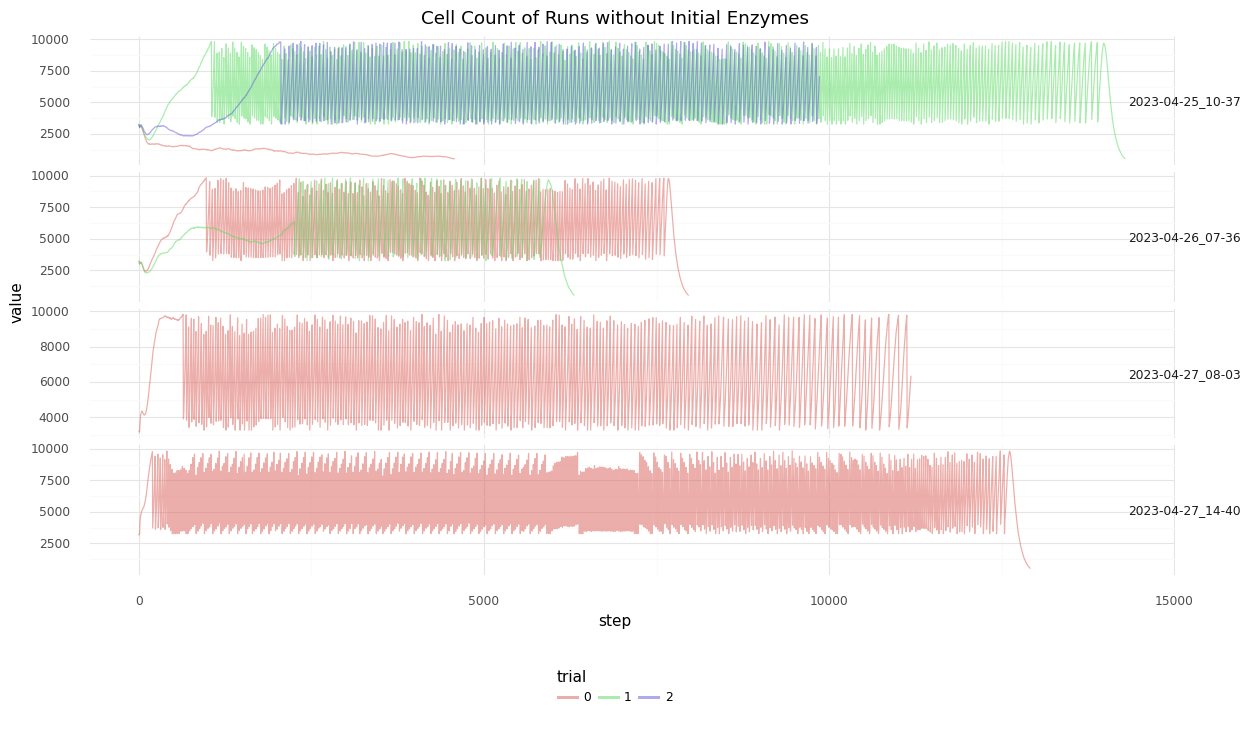

<ggplot: (8760807763665)>

In [153]:
df = pd.merge(scalars_df[scalars_df["scalar"] == "cells"], hparams_df, on="name")
df = df[df["init_enzymes"] == False]

(ggplot(df)
    + geom_line(aes(y="value", x="step", group="name", color="trial"), alpha=0.5)
    + facet_grid("run ~ .", scales="free")
    + theme(figure_size=(14, 7), strip_text_y=element_text(angle=0), legend_position=[0.5, -.05])
    + ggtitle("Cell Count of Runs without Initial Enzymes"))

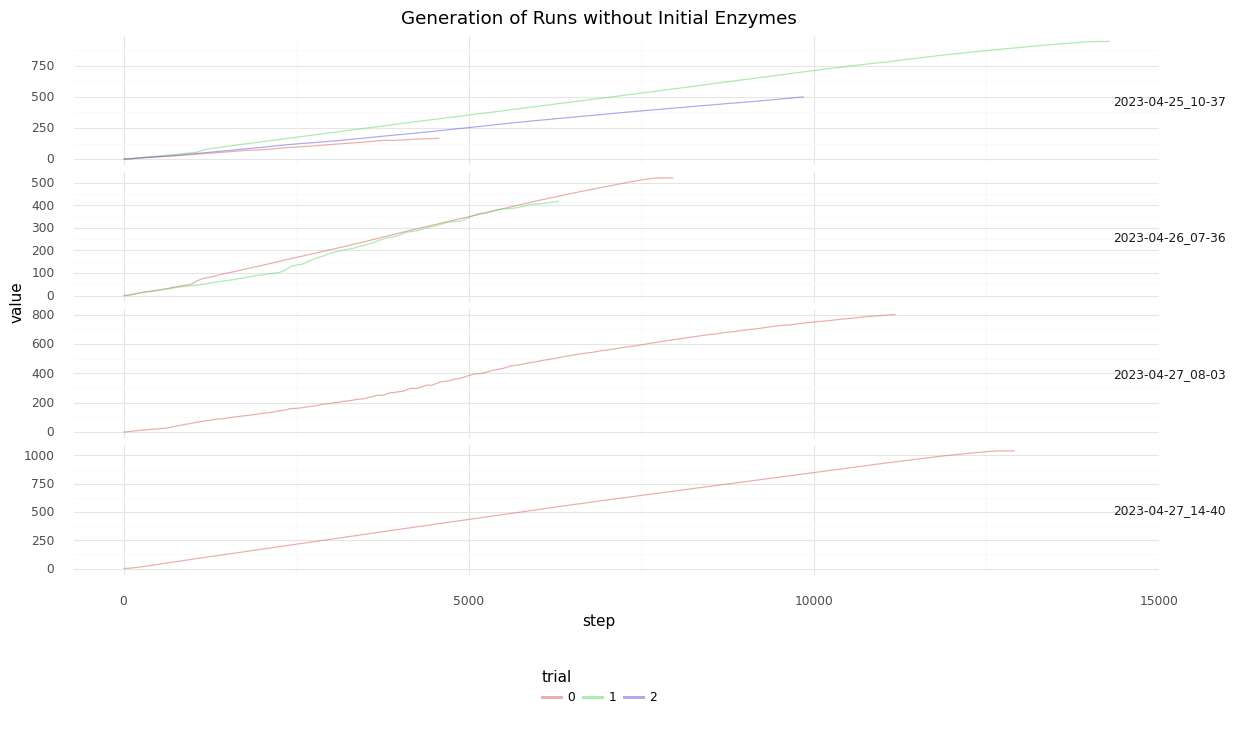

<ggplot: (8760807763635)>

In [152]:
df = pd.merge(scalars_df[scalars_df["scalar"] == "generation"], hparams_df, on="name")
df = df[df["init_enzymes"] == False]

(ggplot(df)
    + geom_line(aes(y="value", x="step", group="name", color="trial"), alpha=0.5)
    + facet_grid("run ~ .", scales="free")
    + theme(figure_size=(14, 7), strip_text_y=element_text(angle=0), legend_position=[0.5, -.05])
    + ggtitle("Generation of Runs without Initial Enzymes"))

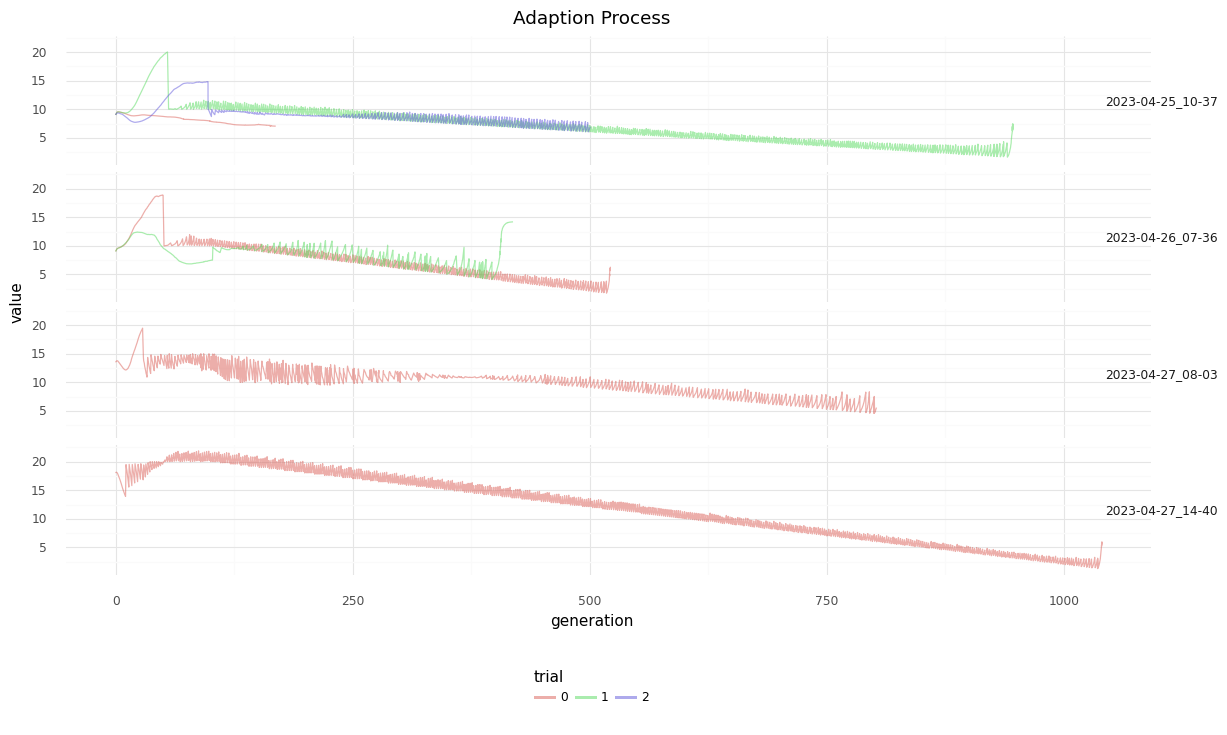

<ggplot: (8760818478408)>

In [158]:
df = hparams_df.loc[hparams_df["init_enzymes"] == False]
df = df.merge(scalars_df[scalars_df["scalar"].isin(["generation", "X[e]"])], on="name")
gens = df.loc[df["scalar"] == "generation", ["value", "step", "name"]].rename(columns={"value": "generation"})
df = df.merge(gens, on=["step", "name"])
df = df[df["scalar"] != "generation"]

(ggplot(df)
    + geom_line(aes(y="value", x="generation", group="name", color="trial"), alpha=0.5)
    + facet_grid("run ~ .", scales="y_free")
    + theme(figure_size=(14, 7), strip_text_y=element_text(angle=0), legend_position=[0.5, -.05])
    + ggtitle("Adaption Process"))

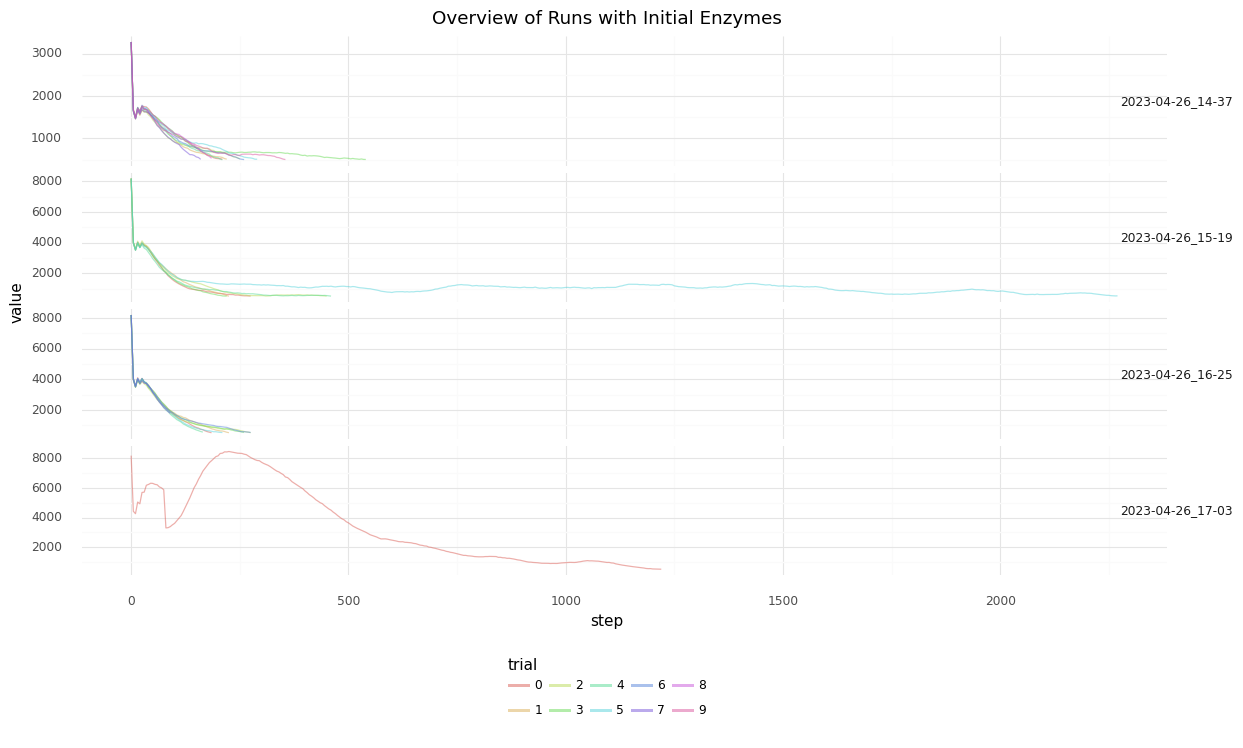

<ggplot: (8760807887095)>

In [154]:
df = pd.merge(scalars_df[scalars_df["scalar"] == "cells"], hparams_df, on="name")
df = df[df["init_enzymes"] == True]

(ggplot(df)
    + geom_line(aes(y="value", x="step", group="name", color="trial"), alpha=0.5)
    + facet_grid("run ~ .", scales="free")
    + theme(figure_size=(14, 7), strip_text_y=element_text(angle=0), legend_position=[0.5, -.05])
    + ggtitle("Cell Count of Runs with Initial Enzymes"))

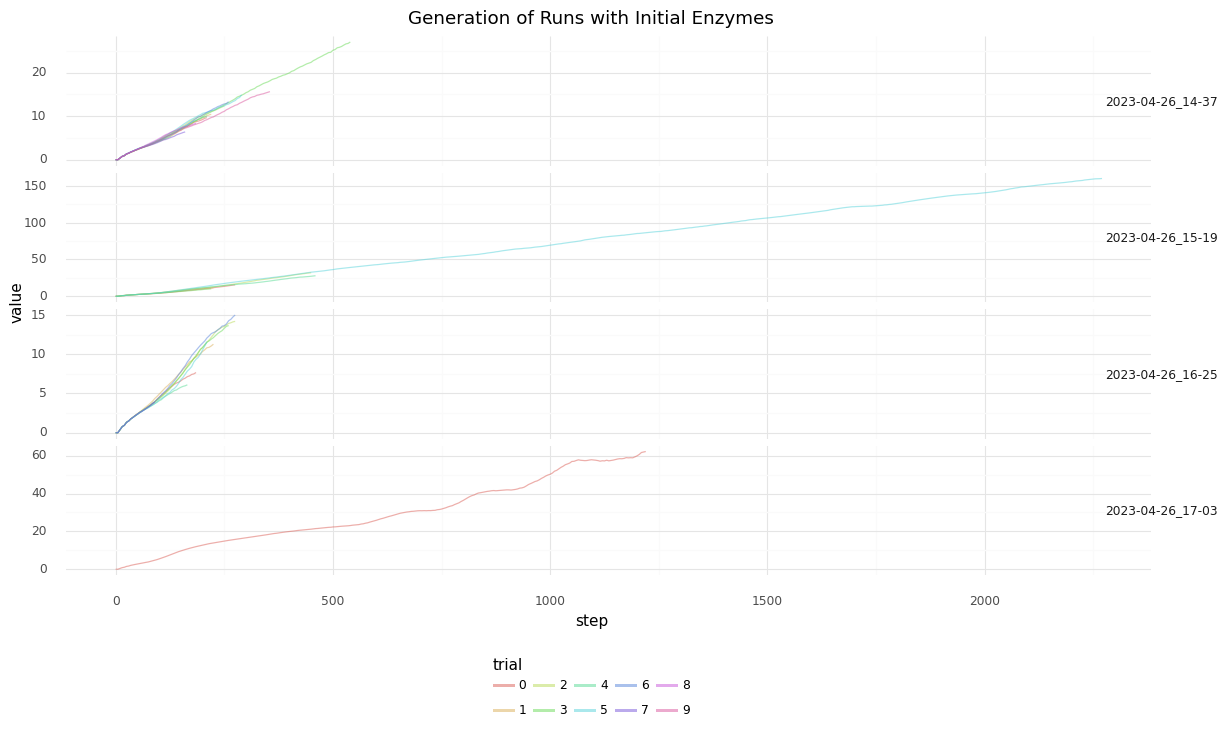

<ggplot: (8760801864461)>

In [155]:
df = pd.merge(scalars_df[scalars_df["scalar"] == "generation"], hparams_df, on="name")
df = df[df["init_enzymes"] == True]

(ggplot(df)
    + geom_line(aes(y="value", x="step", group="name", color="trial"), alpha=0.5)
    + facet_grid("run ~ .", scales="free")
    + theme(figure_size=(14, 7), strip_text_y=element_text(angle=0), legend_position=[0.5, -.05])
    + ggtitle("Generation of Runs with Initial Enzymes"))

In [93]:
RUNS[0]

{'molmap_init': 10.0,
 'n_init_gens': 100.0,
 'n_adapt_gens': 500.0,
 'mut_scheme': 'step',
 'split_ratio': 0.2,
 'split_thresh_cells': 0.6,
 'split_thresh_mols': 0.2,
 'init_enzymes': True,
 'name': '2023-04-26_14-37_7',
 'path': PosixPath('e1_co2_fixing/runs/2023-04-26_14-37_7')}

# Run 2023-04-14_13-17_WL


In [68]:
scalars = [
    ("Cells/total[n]", "cells"),
    ("Cells/Generation", "generation"),
    ("Cells/Survival[avg]", "survival"),
    ("Other/Split", "split")
]

records = []
for path, name in RUNS:
    tf_event_file = next(path.glob("*.out.tfevents.*"))
    tf_ea = event_accumulator.EventAccumulator(str(tf_event_file))
    tf_ea.Reload()
    for tag, label in scalars:
        for obj in tf_ea.Scalars(tag):
            records.append({
                "tag": label,
                "value": obj.value,
                "step": obj.step,
                "trial": name
            })
scalars_df = pd.DataFrame.from_records(records)

In [69]:
records = []
for trial, df in scalars_df.loc[scalars_df["tag"] == "split"].groupby("trial"):
    s = df["value"].diff(periods=1)
    records.extend(df.loc[s > 0.0, ["step", "trial"]].to_dict("records"))
splits_df = pd.DataFrame.from_records(records)
scalars_df = scalars_df[scalars_df["tag"] != "split"]

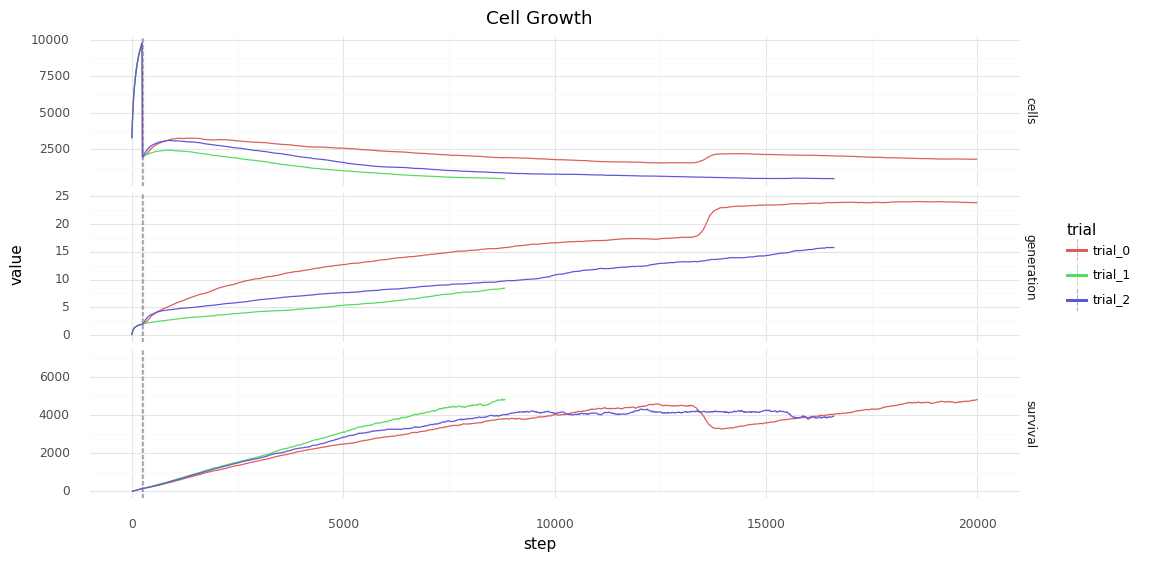

<ggplot: (8758842335812)>

In [94]:
(ggplot(scalars_df)
    + geom_vline(aes(xintercept="step", color="trial"), data=splits_df, linetype="dashed", alpha=0.5)
    + geom_line(aes(y="value", x="step", color="trial"))
    + facet_grid("tag ~ .", scales="free_y")
    + xlim(0, 20_000)
    + theme(figure_size=(12, 6))
    + ggtitle("Cell Growth"))

asd

In [71]:
world = ms.World.from_file(rundir=RUN_DIR_ROOT, device="cpu")
mol_2_idx = {d.name: i for i, d in enumerate(world.chemistry.molecules)}
n_pxls = world.map_size ** 2

In [98]:
main_mols = ["CO2", "X", "Y"]
essential_mols = [d.name for d in ESSENTIAL_MOLS]

records = []
for path, trial in RUNS:
    steps = [int(d.name.split("step=")[-1]) for d in path.glob("step=*")]
    for step in steps:
        world.load_state(statedir=path / f"step={step}", ignore_cell_params=False)
        for mol in main_mols + essential_mols:
            idx = mol_2_idx[mol]
            records.append({
                "trial": trial,
                "molecule": mol,
                "step": step,
                "int": world.cell_molecules[:, idx].sum().item() / world.n_cells,
                "ext": world.molecule_map[idx].sum().item() / n_pxls
            })

molecules_df = pd.DataFrame.from_records(records)
molecules_df["total"] = molecules_df["int"] + molecules_df["ext"]

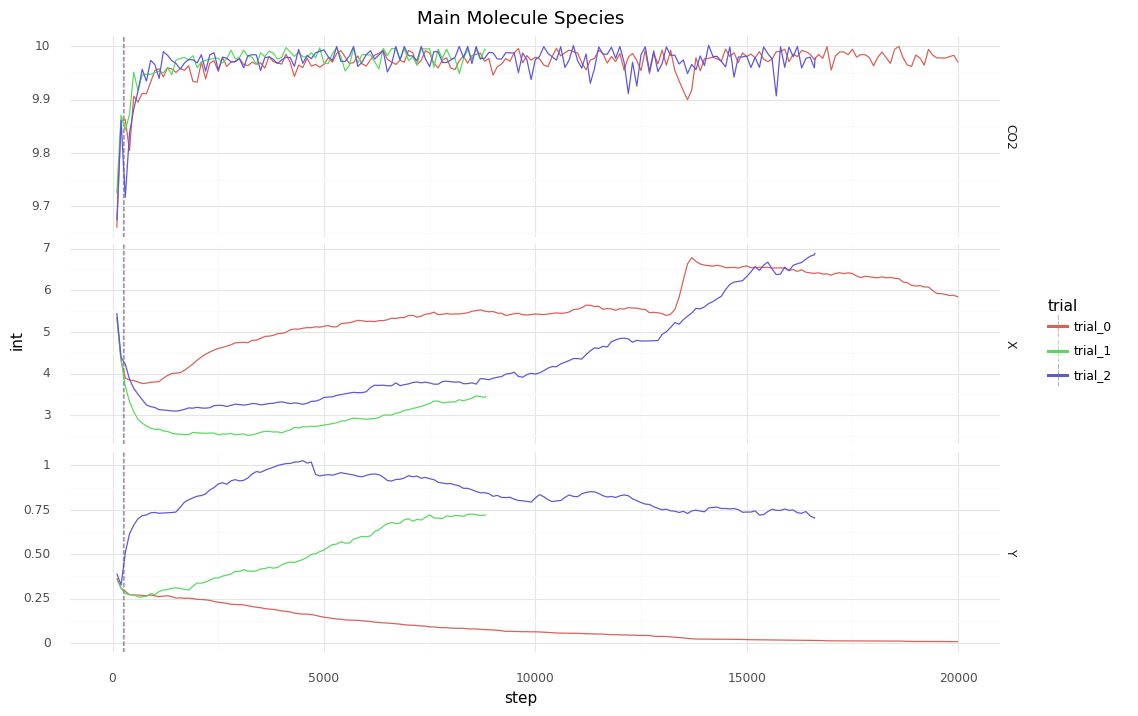

<ggplot: (8758841995484)>

In [101]:
(ggplot(molecules_df[molecules_df["molecule"].isin(main_mols)])
    + geom_vline(aes(xintercept="step", color="trial"), data=splits_df, linetype="dashed", alpha=0.5)
    + geom_line(aes(y="int", x="step", color="trial"))
    + facet_grid("molecule ~ .", scales="free_y")
    + xlim(0, 20_000)
    + theme(figure_size=(12, 8))
    + ggtitle("Main Molecule Species"))

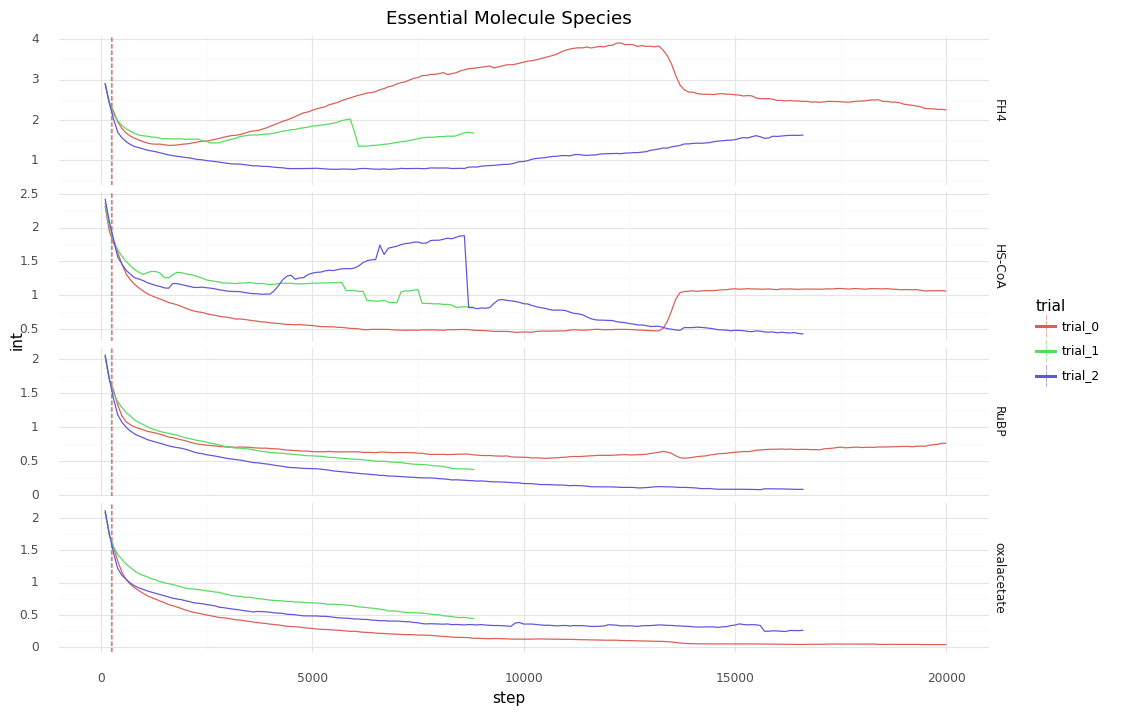

<ggplot: (8758810882021)>

In [105]:
(ggplot(molecules_df[molecules_df["molecule"].isin(essential_mols)])
    + geom_vline(aes(xintercept="step", color="trial"), data=splits_df, linetype="dashed", alpha=0.5)
    + geom_line(aes(y="int", x="step", color="trial"))
    + facet_grid("molecule ~ .", scales="free_y")
    + xlim(0, 20_000)
    + theme(figure_size=(12, 8))
    + ggtitle("Essential Molecule Species"))